# Modified Unified SAXS/WAXS Data Reduction
This notebook combines azimuthal and radial integration functionality from reduce_pyFAI-linkam and Reduce_Normalise_bl17_2_v3

In [1]:
import os
import glob
import numpy as np
import pyFAI
import matplotlib.pyplot as plt
import tifffile
import fabio
import h5py
import json
from tqdm import tqdm
from joblib import Parallel, delayed
from pathlib import Path
from collections import OrderedDict
from functools import reduce
import operator
from natsort import natsorted, os_sorted
import pandas as pd
from dateutil import parser
import re

import warnings
warnings.filterwarnings('ignore')
plt.rcParams.update({'figure.max_open_warning': 50})

## Utility Functions

In [2]:
def set_plot_style(axs, fonts, xlabel, ylabel):
    axs.set_xlabel(xlabel, fontsize=fonts)
    axs.set_ylabel(ylabel, fontsize=fonts)
    axs.tick_params(axis='both', which='major', direction='out', length=4, width=1)
    axs.tick_params(which='minor', width=1, size=2)
    axs.minorticks_on()
    axs.set_facecolor('white')
    for key in axs.spines:
        axs.spines[key].set_linewidth(1)
    axs.tick_params(axis='x', labelsize=fonts)
    axs.tick_params(axis='y', labelsize=fonts)
    return axs

def plot_2d_images(image, poni_file, output_folder, file_label, azm_range, vmin=None, vmax=None):
    ai = pyFAI.load(poni_file)
    pixel_size = ai.pixel1
    detector_distance = ai.dist
    beamx = ai.getFit2D()['centerX']
    beamy = ai.getFit2D()['centerY']
    wavelength = ai.wavelength
    
    x_pixels = image.shape[1]
    y_pixels = image.shape[0]
    x_coords = np.arange(x_pixels) - beamx
    y_coords = np.arange(y_pixels) - beamy
    xx, yy = np.meshgrid(x_coords, y_coords)
    
    qx = 1e-9 * 2 * np.pi / wavelength * np.sin(pixel_size * xx / detector_distance)
    qy = 1e-9 * 2 * np.pi / wavelength * np.sin(pixel_size * yy / detector_distance)
    
    fig, ax = plt.subplots(figsize=(6, 6))
    image = np.nan_to_num(image, nan=0.0)
    image = 10000000 * (image / np.sum(image))
    
    im_avg = ax.pcolormesh(qx, qy, image, cmap='jet', vmin=vmin, vmax=vmax, shading='auto')
    ax.set_aspect('equal')
    
    cbar_avg = fig.colorbar(im_avg, ax=ax, shrink=.8, label='Intensity [a.u.]')
    cbar_avg.ax.tick_params(labelsize=20)
    cbar_avg.ax.yaxis.label.set_size(20)
    
    ax.set_xlabel(r"$q_x$ [nm$^{-1}$]", fontsize=20)
    ax.set_ylabel(r"$q_y$ [nm$^{-1}$]", fontsize=20)
    ax.set_title(f"{file_label}_2D", fontsize=14, y=1.05)
    ax.tick_params(axis='both', which='major', labelsize=20, width=1.5)
    
    output_folder = os.path.join(output_folder, "Figures")
    os.makedirs(output_folder, exist_ok=True)
    plt.savefig(f"{output_folder}/{file_label}.png", dpi=300, bbox_inches='tight')
    plt.close()

def sort_files(filenames):
    def extract_numbers(filename):
        match = re.search(r'_s(\\d+)_0*(\\d+)', filename)
        if match:
            snumber = int(match.group(1))
            number = int(match.group(2))
            return snumber, number
        return float('inf'), float('inf')
    return sorted(filenames, key=extract_numbers)

## TIFF Data Reading Functions

In [3]:
def get_tiff_img_data(fname):
    with tifffile.TiffFile(fname) as tif:
        for idx, page in enumerate(tif.pages):
            if idx == 0:
                img_data = page.asarray().astype(float)
            else:
                img_data = np.concatenate((img_data, page.asarray().astype(float)))
    img_data[img_data > 1e8] = np.nan
    return img_data

def get_tiff_meta_data(fname, df=None): 
    meta_dict = dict()
    with tifffile.TiffFile(fname) as tif:
        tif_tags = {}
        for tag in tif.pages[0].tags.values():
            name, value = tag.name, tag.value
            if name in meta_dict.keys():
                name += '_'
            try:
                meta_dict[name] = json.loads(value)
            except:
                pass 

    # Get motor scanned
    scan_motor = meta_dict['ImageDescription']['SPEC']['SCAN_COLS']['0']

    # Get time when image acquired
    series_start_time = meta_dict['ImageDescription']['Eiger_metadata']['series_date']
    series_start_time = parser.parse(series_start_time).timestamp()
    img_start_time = series_start_time + meta_dict['ImageDescription']['Eiger_metadata']['start_time']
    
    full_dict = {'timestamp' : img_start_time, 'scan_motor': scan_motor}
    
    try:
        motor_names = meta_dict['ImageDescription']['SPEC']['Motor_names']
    except:
        motor_names = {}
    
    motor_vals = meta_dict['ImageDescription']['SPEC']['A']

    try:
        counter_names = meta_dict['ImageDescription']['SPEC']['Counter_names']
    except:
        counter_names = {}
    counter_vals = meta_dict['ImageDescription']['SPEC']['S']
    
    motors = {mname:mval for ((km, mname), (kv, mval)) in zip(motor_names.items(), motor_vals.items())}
    counters = {cname:cval for ((kc, cname), (kc, cval)) in zip(counter_names.items(), counter_vals.items())}
    
    full_dict.update({**motors, **counters})

    try:
        df = pd.concat([df, pd.DataFrame([full_dict])], ignore_index=True)
    except:
        df = pd.DataFrame([full_dict])
    
    return df

def extract_metadata(metadata_df):
    if isinstance(metadata_df, pd.DataFrame) and len(metadata_df) > 0:
        row = metadata_df.iloc[0]
        timestamp = row.get('timestamp', None)
        i0 = row.get('1', None)  # Assuming '1' is i0
        i1 = row.get('2', None)  # Assuming '2' is i1
        Photod = row.get('4', None)  # Assuming '4' is Photod
        return timestamp, i0, i1, Photod
    else:
        return None, 1.0, 1.0, 1.0  # Default values

## HDF5 Data Reading Functions (from reduce_pyFAI-linkam)

In [ ]:
def get_single_image_h5(fname, n, mask=None, threshold=1e7):
    """Read nth frame from EIGER master.h5 via fabio, apply hot-pixel threshold and dead-pixel mask.
    Returns a float image with NaNs where masked/thresholded. Mirrors Linkam IQ path.
    """
    try:
        imgs = fabio.open(fname)
    except Exception:
        return None
    img = imgs.get_frame(n).data.astype(float)
    # hot-pixel threshold to NaN (configurable)
    if threshold is not None:
        img[img > threshold] = np.nan
    # dead-pixel mask to NaN
    if mask is not None:
        img[mask == 1] = np.nan
    return img


def get_nImages(fname):
    """Return number of frames in EIGER master.h5; None if unavailable (signals corrupted scan)."""
    try:
        return fabio.open(fname).nframes
    except Exception:
        return None






## Unified Integration Function

In [ ]:
def integrate_files_unified(
    base_path, poni_file, mask_file, folder, keyword,
    output_base_path, file_type='tiff', nsave2d=3, azm_range=(-60, 60),
    q1=None, q2=None, vmin=None, vmax=None, plot=False, method='splitpixel',
    npt=4000, threshold=1e8, parallel=False, reprocess=False):
    
    # Initialize PyFAI azimuthal integrator
    ai = pyFAI.load(poni_file)
    mask = fabio.open(mask_file).data
    
    # Create output directories
    output_folder = os.path.join(output_base_path, 'OneD_integrated_WAXS_01', folder)
    save_figures_folder = os.path.join(output_folder, 'Figures')
    os.makedirs(save_figures_folder, exist_ok=True)
    
    if file_type == 'tiff':
        # TIFF Processing (adapted from Reduce_Normalise_bl17_2_v3)
        threshold_folders = glob.glob(os.path.join(base_path, folder, keyword, 'Threshold 1'))
        
        if not threshold_folders:
            raise FileNotFoundError("No Threshold folders found.")
        
        for threshold_folder in threshold_folders:
            intermediate_folder = os.path.basename(os.path.dirname(threshold_folder))
            tif_files = [f for f in os.listdir(threshold_folder) if f.endswith('.tif') and not f.startswith('._')]
            tif_files = sort_files(tif_files)
            
            azimuthal_data = []
            radial_data = []
            
            for i, tif_file in enumerate(tqdm(tif_files, desc='Processing TIFF'), start=1):
                file_path = os.path.join(threshold_folder, tif_file)
                
                try:
                    img = get_tiff_img_data(file_path)
                    img[mask == 1] = 0
                except Exception as e:
                    print(f"Error reading {file_path}: {e}")
                    continue
                
                # Get metadata
                eiger_metadata_df = get_tiff_meta_data(file_path)
                real_date_time, i0, i1, Photod = extract_metadata(eiger_metadata_df)
                normfactor = Photod * i1 if (Photod is not None and i1 is not None) else 1.0
                
                azmr = azm_range[1] - azm_range[0]
                
                # Save 2D plots
                if i % nsave2d == 0:
                    plot_2d_images(img, poni_file, output_folder, tif_file, azm_range, vmin, vmax)
                
                # Azimuthal integration
                result = ai.integrate1d(img, npt, error_model='poisson', correctSolidAngle=True, 
                                      azimuth_range=azm_range, normalization_factor=normfactor,
                                      polarization_factor=0.95, method=method, mask=mask)
                q, I_azimuthal, error_azm = result.radial, result.intensity, result.sigma
                azimuthal_data.append((q, I_azimuthal, error_azm, tif_file, real_date_time, i0, i1, Photod))
                
                # Radial integration
                chi, I_radial = ai.integrate_radial(
                    img,
                    npt=720,
                    radial_range=(q1, q2), 
                    azimuth_range=(-180, 0),
                    mask=mask,
                    normalization_factor=normfactor,
                    correctSolidAngle=True,
                    polarization_factor=0.95,
                    method=method,
                    unit='chi_deg',
                    radial_unit='q_nm^-1'
                )
                radial_data.append((chi, I_radial, tif_file, real_date_time, i0, i1, Photod))
            
            # Save azimuthal data in HDF5 format (following v3 format)
            with h5py.File(os.path.join(output_folder, f'{intermediate_folder}_{azmr}_azimuthal_data.h5'), 'w') as hf:
                for idx, (q, I, err, tif_file, real_date_time, i0, i1, Photod) in enumerate(azimuthal_data):
                    group = hf.create_group(f'data_{idx}')
                    group.create_dataset('q', data=q)
                    group.create_dataset('I', data=I)
                    group.create_dataset('error', data=err)
                    group.create_dataset('filename', data=np.string_(tif_file))
                    group.create_dataset('real_date_time', data=np.string_(str(real_date_time)) if real_date_time else b'')
                    group.create_dataset('i0', data=np.float32(i0) if i0 is not None else np.nan)
                    group.create_dataset('i1', data=np.float32(i1) if i1 is not None else np.nan)
                    group.create_dataset('Photod', data=np.float32(Photod) if Photod is not None else np.nan)
            
            # Save radial data in HDF5 format (following v3 format)
            with h5py.File(os.path.join(output_folder, f'{intermediate_folder}_radial_data.h5'), 'w') as hf:
                for idx, (chi, I, tif_file, real_date_time, i0, i1, Photod) in enumerate(radial_data):
                    group = hf.create_group(f'data_{idx}')
                    group.create_dataset('chi', data=chi)
                    group.create_dataset('I', data=I)
                    group.create_dataset('filename', data=np.string_(tif_file))
                    group.create_dataset('real_date_time', data=np.string_(str(real_date_time)) if real_date_time else b'')
                    group.create_dataset('i0', data=np.float32(i0) if i0 is not None else np.nan)
                    group.create_dataset('i1', data=np.float32(i1) if i1 is not None else np.nan)
                    group.create_dataset('Photod', data=np.float32(Photod) if Photod is not None else np.nan)

    elif file_type == 'h5':
        # HDF5 Processing (adapted from reduce_pyFAI-linkam)
        h5_pattern = os.path.join(base_path, folder, f'*{keyword}*_master.h5')
        h5_files = glob.glob(h5_pattern)
        
        if not h5_files:
            h5_pattern = os.path.join(base_path, folder, f'{keyword}_master.h5')
            h5_files = glob.glob(h5_pattern)
        
        for h5_file in h5_files:
            nframes = get_nImages(h5_file)
            azimuthal_data = []
            radial_data = []
            
            def integrate_h5_frame(n):
                img = get_single_image_h5(h5_file, n, mask, threshold=threshold)
                if img is None:
                    return None
                
                # Azimuthal integration
                result = ai.integrate1d(img, npt, correctSolidAngle=True, azimuth_range=azm_range,
                                      polarization_factor=0.95, method=method, mask=mask, unit='q_nm^-1')
                q, I = result.radial, result.intensity
                
                # Radial integration
                chi, I_radial = ai.integrate_radial(
                    img, npt=720, radial_range=(q1, q2), azimuth_range=(-180, 0),
                    mask=mask, correctSolidAngle=True, polarization_factor=0.95,
                    method=method, unit='chi_deg', radial_unit='q_nm^-1')
                
                return (q, I, n), (chi, I_radial, n)
            
            print(f'Processing {os.path.basename(h5_file)} with {nframes} frames...')
            
            if parallel and nframes > 10:
                results = Parallel(n_jobs=-1, require='sharedmem')(delayed(integrate_h5_frame)(n) for n in range(nframes))
            else:
                results = [integrate_h5_frame(n) for n in tqdm(range(nframes), desc='Processing HDF5')]
            
            for res in results:
                if res is None: 
                    continue
                azm, rad = res
                azimuthal_data.append(azm)
                radial_data.append(rad)
            
            # Save HDF5 results (following pyFAI-linkam format)
            basename = os.path.basename(h5_file).replace('_master.h5', '')
            
            # Save azimuthal data
            with h5py.File(os.path.join(output_folder, f'{basename}_azimuthal_processed.h5'), 'w') as h5file:
                q_all = np.array([data[0] for data in azimuthal_data])
                I_all = np.array([data[1] for data in azimuthal_data])
                h5file.create_dataset('q_all', data=q_all)
                h5file.create_dataset('I_all', data=I_all)
            
            # Save radial data
            with h5py.File(os.path.join(output_folder, f'{basename}_radial_processed.h5'), 'w') as h5file:
                chi_all = np.array([data[0] for data in radial_data])
                I_radial_all = np.array([data[1] for data in radial_data])
                h5file.create_dataset('chi_all', data=chi_all)
                h5file.create_dataset('I_radial_all', data=I_radial_all)
    
    else:
        raise ValueError("file_type must be 'tiff' or 'h5'.")
    
    print(f'{file_type.upper()} reduction complete. Files saved in {output_folder}')
    return azimuthal_data, radial_data




## Setup and Usage Example

In [6]:
# Setup paths
base_path = Path(r'/Volumes/SSD1/RawData1/Redesigned_Plastics/May2025/2025_05_Anjani')
save_path = base_path / 'processed_data'
save_path.mkdir(exist_ok=True)

calib_path = base_path / 'calibration'
xye_path = save_path / 'xye_data'
xye_path.mkdir(exist_ok=True) 

calib_file = calib_path / 'LaB6_linkam_15kev.poni'
dp_mask_file1 = calib_path / 'mask_01.edf'

poni_file = str(calib_file)
mask_file = str(dp_mask_file1)
output_base_path = str(save_path)

In [7]:
# Example usage for TIFF files (ex-situ data)
# Uncomment and modify as needed:

# azimuthal_data, radial_data = integrate_files_unified(
#     base_path, poni_file, mask_file, "P3HB", "some_sample_keyword",
#     output_base_path, file_type='tiff', nsave2d=3, azm_range=(-180, 0),
#     q1=9.25, q2=13, vmin=0, vmax=15, plot=True, method='splitpixel', npt=4000
# )

In [8]:
# Example usage for HDF5 files (in-situ/linkam data)
azimuthal_data, radial_data = integrate_files_unified(
    base_path, poni_file, mask_file, "linkam", "Run4_LDPE_30C_50ums_scan001",
    output_base_path, file_type='h5', nsave2d=1, azm_range=(-45, 45),
    q1=14, q2=16, vmin=0, vmax=2, plot=True, method='csr', npt=2000, threshold=1e8, parallel=True
)  

Processing Run4_LDPE_30C_50ums_scan001_master.h5 with 60 frames...
H5 reduction complete. Files saved in /Volumes/SSD1/RawData1/Redesigned_Plastics/May2025/2025_05_Anjani/processed_data/OneD_integrated_WAXS_01/linkam


## Data Loading Functions

In [9]:
def load_existing_data(iq_file):
    """Load data from HDF5 files created by pyFAI-linkam style processing"""
    with h5py.File(iq_file, 'r') as h5file:
        return h5file['q_all'][:], h5file['I_all'][:]

def load_existing_radial_data(radial_file):
    """Load radial data from HDF5 files"""
    with h5py.File(radial_file, 'r') as h5file:
        return h5file['chi_all'][:], h5file['I_radial_all'][:]

def read_h5_data(base_path, samp_folder, keyword, azimuthal=True):
    """
    Read azimuthal or radial data from HDF5 files generated by integrate_files_unified (v3 style).
    """
    target_folder = os.path.join(base_path, 'OneD_integrated_WAXS_01', samp_folder)
    if not os.path.exists(target_folder):
        raise FileNotFoundError(f"Target folder does not exist: {target_folder}")

    pattern = f"*{keyword}*_azimuthal_data.h5" if azimuthal else f"*{keyword}*_radial_data.h5"
    h5_files = glob.glob(os.path.join(target_folder, pattern))

    if not h5_files:
        raise FileNotFoundError(f"No matching HDF5 files found in {target_folder} with pattern {pattern}")

    data_list = []

    for h5_path in h5_files:
        with h5py.File(h5_path, 'r') as hf:
            for key in hf:
                group = hf[key]
                data = {
                    "filename": group["filename"][()].decode() if isinstance(group["filename"][()], bytes) else group["filename"][()],
                    "real_date_time": group["real_date_time"][()].decode() if isinstance(group["real_date_time"][()], bytes) else group["real_date_time"][()],
                    "i0": group["i0"][()],
                    "i1": group["i1"][()],
                    "Photod": group["Photod"][()]
                }
                if azimuthal:
                    data.update({
                        "q": group["q"][()],
                        "I": group["I"][()],
                        "error": group["error"][()]
                    })
                else:
                    data.update({
                        "chi": group["chi"][()],
                        "I": group["I"][()]
                    })
                data_list.append(data)

    return data_list

## Plotting Functions

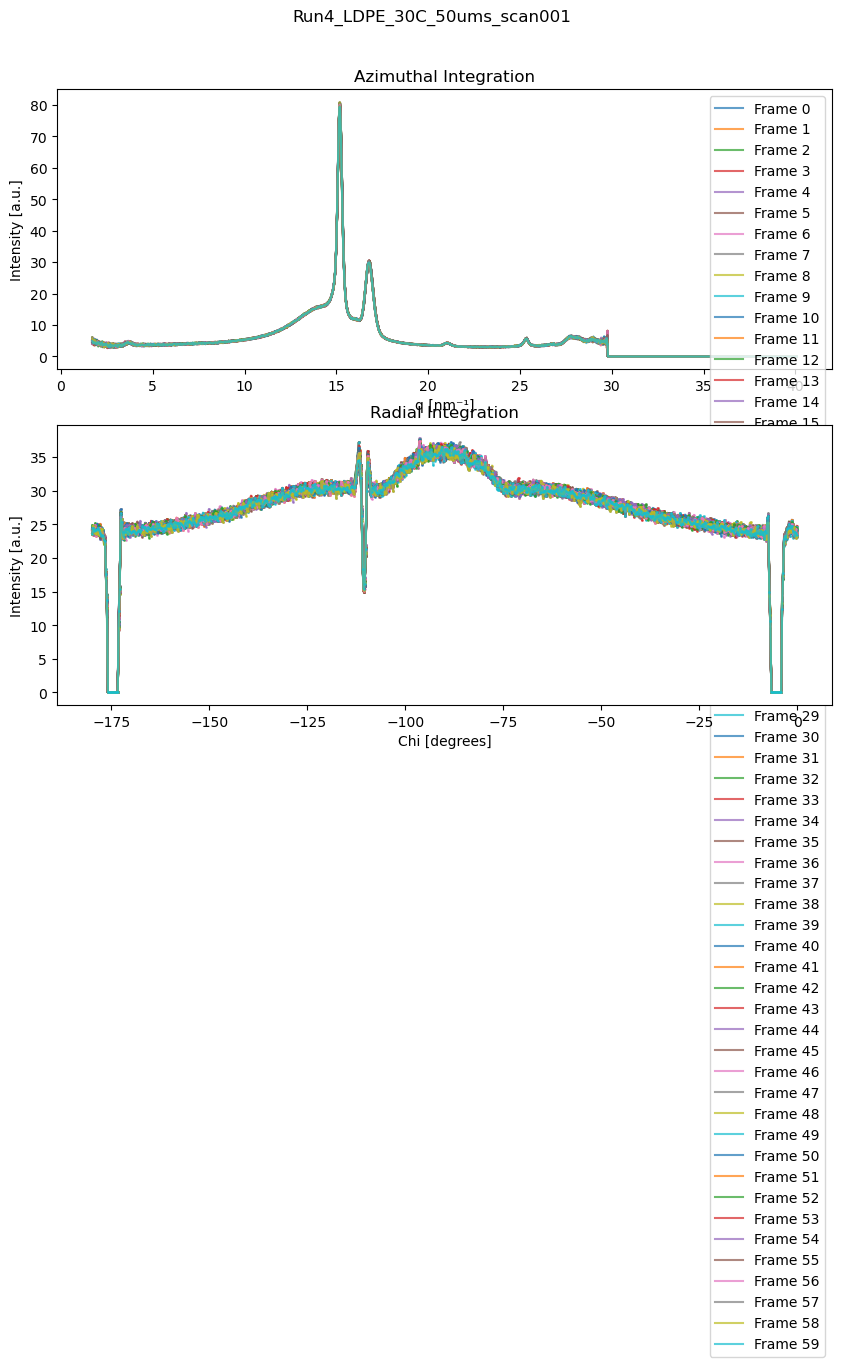

In [11]:
def plot_integrated_data(azimuthal_data, radial_data, title="Integrated Data"):
    """Plot both azimuthal and radial integration results"""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
    
    # Plot azimuthal data
    for i, (q, I, *_) in enumerate(azimuthal_data):  # Plot first 5 for visibility
        ax1.plot(q, I, label=f'Frame {i}', alpha=0.7)
    
    ax1.set_xlabel('q [nm⁻¹]')
    ax1.set_ylabel('Intensity [a.u.]')
    ax1.set_title('Azimuthal Integration')
    ax1.legend()
    
    # Plot radial data
    for i, (chi, I, *_) in enumerate(radial_data):  # Plot first 5 for visibility
        ax2.plot(chi, I, 'o-', markersize=1, label=f'Frame {i}', alpha=0.7)
    
    ax2.set_xlabel('Chi [degrees]')
    ax2.set_ylabel('Intensity [a.u.]')
    ax2.set_title('Radial Integration')
    #ax2.legend()
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


# Example plotting of the processed data
plot_integrated_data(azimuthal_data, radial_data, title="Run4_LDPE_30C_50ums_scan001")